In [59]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, normalize
from sklearn.cluster import DBSCAN, OPTICS
from hdbscan import HDBSCAN

import os
import re
import gower
import graphviz
from pprint import pprint

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# Loading data
train_df = pd.read_csv('../training.csv')
train_orig_df = train_df.copy()
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,0,1.00000,0,0,0,0,0,1,5,male,1,0,1,marketing,6,0.99962,146,liked,male,1,0,1,marketing,5,0.99899,22636,viewed,male,0,0,1,other,4,0.23077,3080,viewed,male,0,0,1,marketing,3,0.23077,44661,viewed,male,0,0,1,other,2,0.23077,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,2,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,146,commented,male,1,0,1,marketing,4,0.99899,22636,viewed,male,0,0,1,other,3,0.23077,3080,viewed,male,0,0,1,marketing,2,0.23077,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,3,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,13,commented,male,1,0,1,marketing,4,0.99895,146,commented,male,1,0,1,marketing,3,0.99899,22636,viewed,male,0,0,1,other,2,0.23077,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


### Autoencoder Preprocessing

In [61]:
# Get rid of redundant columns
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_lead', 'participant1_order',
                  'participant2_is_lead', 'participant2_order',
                  'participant3_is_lead', 'participant3_order',
                  'participant4_is_lead', 'participant4_order',
                  'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in train_df.columns if i not in redundant_cols]

train_df = train_df[useful_cols]

In [62]:
all_cols = [col for col in train_df.columns]
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 28
Amount of categorical columns: 19


In [63]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

train_enc_df = train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

print('Shape of encoded dataframe -> {}'.format(train_enc_df.shape))
train_enc_df.head()

Shape of encoded dataframe -> (9418, 88)


,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_is_in_connections,poster_influence,participant1_is_employee,participant1_is_in_connections,participant1_influence,participant2_is_employee,participant2_is_in_connections,participant2_influence,participant3_is_employee,participant3_is_in_connections,participant3_influence,participant4_is_employee,participant4_is_in_connections,participant4_influence,participant5_is_employee,participant5_is_in_connections,participant5_influence,rank,app_type_calendar,app_type_forum,app_type_other,app_type_poll,app_type_social,app_type_wiki,owner_type_space,owner_type_user,poster_gender_female,poster_gender_male,poster_focus_engineering,poster_focus_marketing,poster_focus_none,poster_focus_other,poster_focus_sales,participant1_action_commented,participant1_action_liked,participant1_action_viewed,participant1_gender_female,participant1_gender_male,participant1_focus_engineering,participant1_focus_marketing,participant1_focus_other,participant1_focus_sales,participant2_action_commented,participant2_action_liked,participant2_action_viewed,participant2_gender_female,participant2_gender_male,participant2_focus_engineering,participant2_focus_marketing,participant2_focus_other,participant2_focus_sales,participant3_action_commented,participant3_action_liked,participant3_action_viewed,participant3_gender_female,participant3_gender_male,participant3_focus_engineering,participant3_focus_marketing,participant3_focus_other,participant3_focus_sales,participant4_action_commented,participant4_action_liked,participant4_action_viewed,participant4_gender_female,participant4_gender_male,participant4_focus_engineering,participant4_focus_marketing,participant4_focus_other,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.99973,1,0,1.00000,0,0,0,0,0,1,1,0.99962,1,1,0.99899,0,1,0.23077,0,1,0.23077,0,1,0.23077,0,1,0.23077,0.73677,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.99977,0,2,0.12336,0,0,0,1,0,0,1,0.99899,0,0,0.99756,1,1,0.99899,0,1,0.23077,0,1,0.23077,0,1,0.23077,0.78240,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.99977,0,3,0.12336,0,0,0,1,0,0,1,0.99899,0,0,0.99756,1,1,0.99895,1,1,0.99899,0,1,0.23077,0,1,0.23077,0.82125,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.99949,0,0,0.00000,0,0,0,0,0,0,1,0.99886,0,1,0.23077,0,1,0.23077,0,1,0.23077,0,1,0.23077,0,1,0.23077,0.61522,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.99949,0,0,0.00000,0,0,0,0,0,0,1,0.99886,0,1,0.23077,0,1,0.23077,0,1,0.23077,0,1,0.23077,0,1,0.23077,0.61522,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [64]:
# Normalization

x = train_enc_df.values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

norm_df = pd.DataFrame(x_scaled)
norm_df.index = train_enc_df.index
rename_to_new = {old: new for old, new in zip(list(range(norm_df.shape[1])), train_enc_df.columns)}
norm_df = norm_df.rename(rename_to_new, axis=1)

norm_df.head()

,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_is_in_connections,poster_influence,participant1_is_employee,participant1_is_in_connections,participant1_influence,participant2_is_employee,participant2_is_in_connections,participant2_influence,participant3_is_employee,participant3_is_in_connections,participant3_influence,participant4_is_employee,participant4_is_in_connections,participant4_influence,participant5_is_employee,participant5_is_in_connections,participant5_influence,rank,app_type_calendar,app_type_forum,app_type_other,app_type_poll,app_type_social,app_type_wiki,owner_type_space,owner_type_user,poster_gender_female,poster_gender_male,poster_focus_engineering,poster_focus_marketing,poster_focus_none,poster_focus_other,poster_focus_sales,participant1_action_commented,participant1_action_liked,participant1_action_viewed,participant1_gender_female,participant1_gender_male,participant1_focus_engineering,participant1_focus_marketing,participant1_focus_other,participant1_focus_sales,participant2_action_commented,participant2_action_liked,participant2_action_viewed,participant2_gender_female,participant2_gender_male,participant2_focus_engineering,participant2_focus_marketing,participant2_focus_other,participant2_focus_sales,participant3_action_commented,participant3_action_liked,participant3_action_viewed,participant3_gender_female,participant3_gender_male,participant3_focus_engineering,participant3_focus_marketing,participant3_focus_other,participant3_focus_sales,participant4_action_commented,participant4_action_liked,participant4_action_viewed,participant4_gender_female,participant4_gender_male,participant4_focus_engineering,participant4_focus_marketing,participant4_focus_other,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.999789,0.015625,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,0.999307,0.0,1.0,0.153910,0.0,1.0,0.153910,0.0,1.0,0.15391,0.0,1.0,0.15391,0.802200,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.999833,0.000000,0.013793,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.999307,0.0,0.0,0.997733,1.0,1.0,0.999307,0.0,1.0,0.153910,0.0,1.0,0.15391,0.0,1.0,0.15391,0.858218,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.999833,0.000000,0.020690,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.999307,0.0,0.0,0.997733,1.0,1.0,0.999263,1.0,1.0,0.999307,0.0,1.0,0.15391,0.0,1.0,0.15391,0.905912,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.999164,0.0,1.0,0.153910,0.0,1.0,0.153910,0.0,1.0,0.153910,0.0,1.0,0.15391,0.0,1.0,0.15391,0.652978,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.999164,0.0,1.0,0.153910,0.0,1.0,0.153910,0.0,1.0,0.153910,0.0,1.0,0.15391,0.0,1.0,0.15391,0.652978,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.

In [65]:
X_train, X_valid = train_test_split(norm_df, train_size=0.85, shuffle=True, random_state=1)

print('Shape of X_train = {}'.format(X_train.shape))
print('Shape of X_valid = {}'.format(X_valid.shape))

Shape of X_train = (8005, 88)
Shape of X_valid = (1413, 88)


In [66]:
# Creating noise data
noise_factor = 0.3
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) - noise_factor / 2
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) - noise_factor / 2
X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)

### Building Autoencoder

In [67]:
autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(35, activation='linear', name='bottleneck'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

In [68]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_noisy, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid_noisy, X_valid))

Epoch 1/100
32/32 [==============================] - 0s 13ms/step - loss: 0.1688 - val_loss: 0.1172
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1021 - val_loss: 0.0875
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0760 - val_loss: 0.0648
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0599 - val_loss: 0.0554
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0527 - val_loss: 0.0496
Epoch 6/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0477 - val_loss: 0.0456
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0442 - val_loss: 0.0426
Epoch 8/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0414 - val_loss: 0.0401
Epoch 9/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0390 - val_loss: 0.0383
Epoch 10/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0371 - val_loss: 0.0369
Epoch 1

Epoch 83/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0123 - val_loss: 0.0158
Epoch 84/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0121 - val_loss: 0.0157
Epoch 85/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0121 - val_loss: 0.0155
Epoch 86/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0156
Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0120 - val_loss: 0.0156
Epoch 88/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0118 - val_loss: 0.0154
Epoch 89/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0156
Epoch 90/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0155
Epoch 91/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0154
Epoch 92/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0151


In [69]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 35

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

### Clustering Preprocessing

In [70]:
encoded_train_df = pd.DataFrame(encoder.predict(norm_df))
print("Dataframe from latent vectors of processed dataset has shape = {}.".format(encoded_train_df.shape))
encoded_train_df.head()

Dataframe from latent vectors of processed dataset has shape = (9418, 35).


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,-1.832391,6.433290,-10.850679,-2.551519,-4.683195,3.476334,9.411875,0.935370,-3.220172,7.888866,3.371792,2.001075,-5.066909,2.194260,-4.341808,4.988245,-10.875356,12.787680,-4.396412,-3.960745,-5.463553,6.959070,-1.357392,10.281818,3.990929,6.192941,8.459577,-2.016294,5.476612,-4.285187,0.828807,-6.817134,13.692098,-3.756307,-1.137491
1,-4.285604,8.467966,-7.168481,0.096526,-0.808817,0.152065,7.586650,-9.244932,-0.117898,1.616789,1.971704,-2.299466,2.481759,-3.016922,-2.684736,2.041699,-13.244493,13.134483,-5.831230,-3.733853,-6.991389,5.552796,3.431895,0.090324,8.719346,9.117218,9.059245,-5.842284,2.319491,1.215560,-0.272443,-13.018007,11.315148,3.573542,1.473617
2,-4.533022,6.809583,-14.779541,-1.706529,-3.444461,3.802060,11.085310,-6.766944,3.279433,1.776073,3.933949,-3.539661,-0.344808,-4.525501,-1.567702,-1.225149,-8.723471,14.361617,1.322117,-7.894619,-6.963840,2.315520,2.245665,-0.533713,5.726785,7.698745,12.139681,-0.690850,4.943056,3.915781,-2.344649,-14.970715,11.942893,3.299896,6.374135
3,1.629539,8.529494,-12.263910,2.046180,-0.126264,5.972017,6.360660,-6.800884,0.432457,6.930753,3.327161,-2.318295,-2.829117,4.490241,-6.165419,5.737714,-10.288591,14.349190,-1.702227,-8.385081,-6.771456,3.718509,0.188562,0.634376,4.062107,4.647886,5.292390,-4.676350,-0.551638,4.699846,-0.485536,-7.162076,8.989219,-2.045865,0.815950
4,1.629539,8.529494,-12.263910,2.046180,-0.126264,5.972017,6.360660,-6.800884,0.432457,6.930753,3.327161,-2.318295,-2.829117,4.490241,-6.165419,5.737714,-10.288591,14.349190,-1.702227,-8.385081,-6.771456,3.718509,0.188562,0.634376,4.062107,4.647886,5.292390,-4.676350,-0.551638,4.699846,-0.485536,-7.162076,8.989219,-2.045865,0.815950


In [71]:
# Need this for "normalized" clustering with cosine distance
# (normalization in sklearn equals to using cosine distance using K-Means clustering)
normalized_vectors = normalize(encoded_train_df)
print(normalized_vectors.shape)

(9418, 35)


In [72]:
# Calculating gower distance for future usage.
d = gower.gower_matrix(data_x=normalized_vectors)
print(d)

[[0.         0.16941462 0.17471309 ... 0.17866068 0.22730316 0.20864701]
 [0.16941462 0.         0.09952803 ... 0.19939984 0.20728095 0.18310541]
 [0.17471309 0.09952803 0.         ... 0.19261493 0.20270471 0.20964234]
 ...
 [0.17866068 0.19939984 0.19261493 ... 0.         0.13393897 0.09183565]
 [0.22730316 0.20728095 0.20270471 ... 0.13393897 0.         0.10849399]
 [0.20864701 0.18310541 0.20964234 ... 0.09183565 0.10849399 0.        ]]


### Clustering

#### DBSCAN

In [73]:
# Using sklearn implementation of DBSCAN algorithm
dbscan = DBSCAN(eps=0.05, min_samples=100, metric='precomputed').fit(d)
print(np.unique(dbscan.labels_))

[-1  0  1  2  3  4  5]


In [74]:
# Showing number of news in each cluster
unique_elements, counts_elements = np.unique(dbscan.labels_, return_counts=True)
for i in range(len(unique_elements)):
    print("Cluster {} contains {} news.".format(unique_elements[i], counts_elements[i]))

Cluster -1 contains 7131 news.
Cluster 0 contains 250 news.
Cluster 1 contains 1275 news.
Cluster 2 contains 210 news.
Cluster 3 contains 214 news.
Cluster 4 contains 209 news.
Cluster 5 contains 129 news.


#### OPTICS

In [84]:
# Using sklearn implementation of OPTICS algorithm
optics = OPTICS(min_samples=75, metric='precomputed').fit(d)
print(np.unique(optics.labels_))

[-1  0  1  2  3  4  5  6  7  8  9]


In [85]:
# Showing number of news in each cluster
unique_elements, counts_elements = np.unique(optics.labels_, return_counts=True)
for i in range(len(unique_elements)):
    print("Cluster {} contains {} news.".format(unique_elements[i], counts_elements[i]))

Cluster -1 contains 7950 news.
Cluster 0 contains 108 news.
Cluster 1 contains 203 news.
Cluster 2 contains 184 news.
Cluster 3 contains 165 news.
Cluster 4 contains 234 news.
Cluster 5 contains 88 news.
Cluster 6 contains 118 news.
Cluster 7 contains 122 news.
Cluster 8 contains 88 news.
Cluster 9 contains 158 news.


#### HDBSCAN

In [77]:
# HDBSCAN algorithm: http://hdbscan.readthedocs.io/en/latest/
hdbscan = HDBSCAN(min_cluster_size=100, min_samples=15, metric='precomputed').fit(d.astype('double'))
print(np.unique(hdbscan.labels_))

[-1  0  1  2  3  4  5  6  7]


In [83]:
# Showing number of news in each cluster
unique_elements, counts_elements = np.unique(hdbscan.labels_, return_counts=True)
for i in range(len(unique_elements)):
    print("Cluster {} contains {} news.".format(unique_elements[i], counts_elements[i]))

Cluster -1 contains 2758 news.
Cluster 0 contains 128 news.
Cluster 1 contains 213 news.
Cluster 2 contains 165 news.
Cluster 3 contains 234 news.
Cluster 4 contains 122 news.
Cluster 5 contains 118 news.
Cluster 6 contains 1165 news.
Cluster 7 contains 4515 news.


### Visualization

In [78]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import animation
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [79]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components, random_state=1).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    colors = plt.get_cmap('tab10').colors
    colors = plt.get_cmap('Set3').colors
    N = 360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for label in tsne_3d_df[label_column].unique():
        label_df = tsne_3d_df[tsne_3d_df[label_column] == label]
        sc = ax.scatter(label_df['x'], label_df['y'], label_df['z'], c=colors[label],
               label=f"Cluster {label}", s=6, depthshade=True)
  
    ax.legend(loc='upper right')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('dbscan_results/{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [80]:
final_df = encoded_train_df.copy()
final_df['rank'] = train_orig_df['rank']

In [86]:
tsne_3d_df = prepare_tsne(3, final_df, dbscan.labels_)
tsne_3d_df['optics'] = optics.labels_
tsne_3d_df['hdbscan'] = hdbscan.labels_

tsne_3d_df.head()

,x,y,z,labels,optics,hdbscan
0,-4.890093,-16.214771,16.360802,0,-1,6
1,11.598636,-26.334068,-2.660598,-1,-1,7
2,7.154345,-2.081608,-18.476912,-1,-1,7
3,-18.042837,12.039824,-3.981893,1,4,3
4,-18.042837,12.039824,-3.981893,1,4,3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

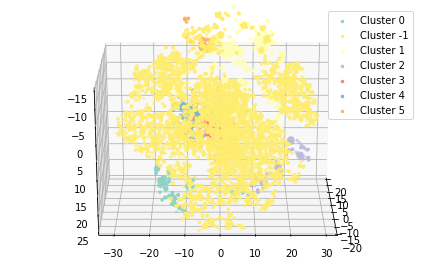

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

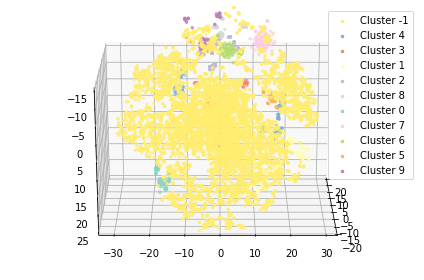

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

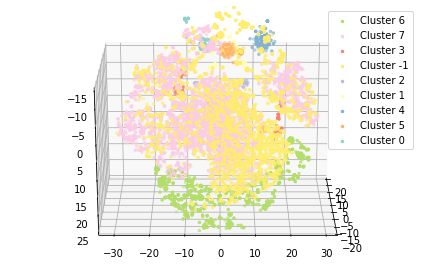

In [87]:
plot_animation(tsne_3d_df, 'labels', 'dbscan')
plot_animation(tsne_3d_df, 'optics', 'optics')
plot_animation(tsne_3d_df, 'hdbscan', 'hdbscan')